In [ ]:
import tensorflow as tf
import gc
import os
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 1.4 MB/s eta 0:00:00
Mounted at /gdrive
/gdrive


In [ ]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_front =   tf.keras.models.load_model('/gdrive/My Drive/Model_run_v1/Frontal', options=load_locally)
    reconstructed_left=     tf.keras.models.load_model('/gdrive/My Drive/Model_run_v1/Left', options=load_locally)
    reconstructed_right =   tf.keras.models.load_model('/gdrive/My Drive/Model_run_v1/Right', options=load_locally)
    reconstructed_left45=   tf.keras.models.load_model('/gdrive/My Drive/Model_run_v1/Left45', options=load_locally)
    reconstructed_right45 = tf.keras.models.load_model('/gdrive/My Drive/Model_run_v1/Right45', options=load_locally)

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Frontal.hkl")
X_train_frontal=load_hkl['xtrain'] / 255.
X_test_frontal=load_hkl['xtest'] / 255.
y_train_frontal=load_hkl['ytrain']
y_test_frontal=load_hkl['ytest']
del load_hkl
gc.collect()

475

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Left.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()


0

In [ ]:

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Right.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

0

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Left45.hkl")
X_train_left45=load_hkl['xtrain'] / 255.
X_test_left45=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()


0

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Right45.hkl")
X_train_right45=load_hkl['xtrain'] / 255.
X_test_right45=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

0

In [ ]:
xm_train_frontal=reconstructed_front.encoder(X_train_frontal)
xm_test_frontal=reconstructed_front.encoder(X_test_frontal)
del X_train_frontal
del X_test_frontal
gc.collect()

0

In [ ]:
xm_train_left=reconstructed_left.encoder(X_train_left)
xm_test_left=reconstructed_left.encoder(X_test_left)
del X_train_left
del X_test_left
gc.collect()

0

In [ ]:
xm_train_right=reconstructed_right.encoder(X_train_right)
xm_test_right=reconstructed_right.encoder(X_test_right)
del X_train_right
del X_test_right
gc.collect()

0

In [ ]:
xm_train_left45=reconstructed_left45.encoder(X_train_left45)
xm_test_left45=reconstructed_left45.encoder(X_test_left45)
del X_train_left45
del X_test_left45
gc.collect()

0

In [ ]:
xm_train_right45=reconstructed_right45.encoder(X_train_right45)
xm_test_right45=reconstructed_right45.encoder(X_test_right45)
del X_train_right45
del X_test_right45
gc.collect()

0

# **Fusion of front, left,right,left45, and right45 vectors**

In [ ]:
class CNN_Views(Model):
    def __init__(self):
        super(CNN_Views, self).__init__()
        self.front = tf.keras.Sequential([
            layers.Input(shape=xm_train_frontal.shape[1:]),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(20,activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(10,activation='relu')])

        self.left = tf.keras.Sequential([
            layers.Input(shape=xm_train_left.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(2, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(5,activation='relu')])

        self.right = tf.keras.Sequential([
            layers.Input(shape=xm_train_right.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(2, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5,activation='relu')])

        self.left45 = tf.keras.Sequential([
            layers.Input(shape=xm_train_left45.shape[1:]),
            layers.Conv2D(3, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(1, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5, activation='relu')])

        self.right45 = tf.keras.Sequential([
            layers.Input(shape=xm_train_right45.shape[1:]),
            layers.Conv2D(3, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(1, 3, strides=1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(10,activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5, activation='relu')])

        self.combine = tf.keras.Sequential([
            layers.Input(shape=(30,)),
            layers.Dense(30, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')])

    def call(self, x):
        front = self.front(x[0])
        left = self.left(x[1])
        right = self.right(x[2])
        left45 = self.left45(x[3])
        right45 = self.right45(x[4])

        out=self.combine(layers.Concatenate(axis=1)([front,left,right,left45,right45]))

        return out


## **Deep Learning**

In [ ]:
epochs=30

In [ ]:
with strategy.scope():
  cnn_combined=CNN_Views()
  cnn_combined.compile(optimizer='adam',  loss='binary_crossentropy',metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5))
history=cnn_combined.fit([xm_train_frontal, xm_train_left, xm_train_right, xm_train_left45, xm_train_right45],y_train_frontal, epochs=epochs,
      batch_size=16, shuffle=True)

Epoch 1/30
13/13 [==============================] - 18s 73ms/step - loss: 0.6880 - binary_accuracy: 0.5361
Epoch 2/30
13/13 [==============================] - 1s 71ms/step - loss: 0.6679 - binary_accuracy: 0.5567
Epoch 3/30
13/13 [==============================] - 1s 72ms/step - loss: 0.6294 - binary_accuracy: 0.6495
Epoch 4/30
13/13 [==============================] - 1s 72ms/step - loss: 0.5776 - binary_accuracy: 0.7371
Epoch 5/30
13/13 [==============================] - 1s 73ms/step - loss: 0.5062 - binary_accuracy: 0.7474
Epoch 6/30
13/13 [==============================] - 1s 70ms/step - loss: 0.4405 - binary_accuracy: 0.7938
Epoch 7/30
13/13 [==============================] - 1s 71ms/step - loss: 0.3712 - binary_accuracy: 0.8299
Epoch 8/30
13/13 [==============================] - 1s 70ms/step - loss: 0.4209 - binary_accuracy: 0.8196
Epoch 9/30
13/13 [==============================] - 1s 70ms/step - loss: 0.3835 - binary_accuracy: 0.8711
Epoch 10/30
13/13 [==========================

In [ ]:
#,validation_data=([xm_test_frontal, xm_test_left, xm_test_right, xm_test_left45, xm_test_right45],y_test_frontal)

In [ ]:
cnn_combined.evaluate([xm_test_frontal, xm_test_left, xm_test_right, xm_test_left45, xm_test_right45], y_test_frontal,return_dict=True)

3/3 [==============================] - 8s 1s/step - loss: 0.5391 - binary_accuracy: 0.9036


{'loss': 0.5391408205032349, 'binary_accuracy': 0.9036144614219666}

In [ ]:
import seaborn as sns

In [ ]:
y_pred=cnn_combined.predict([xm_test_frontal, xm_test_left, xm_test_right, xm_test_left45, xm_test_right45])

3/3 [==============================] - 8s 2s/step


In [ ]:
y_pred=np.where(y_pred > 0.5, 1,0)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

cm=confusion_matrix(y_test_frontal, y_pred)
print(cm)
print(classification_report(y_test_frontal, y_pred))

[[48  5]
 [ 3 27]]
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92        53
         1.0       0.84      0.90      0.87        30

    accuracy                           0.90        83
   macro avg       0.89      0.90      0.90        83
weighted avg       0.91      0.90      0.90        83



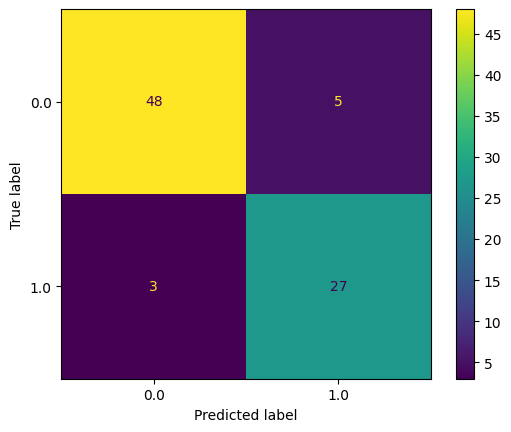

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0','1.0'])
sns.reset_orig()
disp.plot()